In [3]:
import pyvista as pv
import numpy as np


In [ ]:
import os
def load_mesh_from_folder(remeshed_path, clipped_path):
    """Load mesh data from a folder containing remeshed and clipped samples.
    Args:
        remeshed_path (str): Path to the folder containing remeshed samples.
        clipped_path (str): Path to the folder containing clipped samples.
    Returns:
        list: A list of tuples containing (remeshed_mesh_path, clipped_mesh_path).
    """
    mesh_pairs = []
    samples_path = os.path.join(remeshed_path, 'dataset', 'samples')
    for samples_name in sorted(os.listdir(samples_path)):
        if not samples_name.startswith('sample_'):
            continue
            
        remeshed_mesh_dir = os.path.join(samples_path, samples_name, 'meshes')
        clipped_mesh_dir = os.path.join(clipped_path, 'dataset', 'samples', samples_name, 'meshes')
        remeshed_scalar_path = os.path.join(samples_path, samples_name, 'scalars.csv')
        clipped_scalar_path = os.path.join(clipped_path, 'dataset', 'samples', samples_name, 'scalars.csv')
        
        if not os.path.isdir(remeshed_mesh_dir) or not os.path.isdir(clipped_mesh_dir):
            continue 
            
        remeshed_mesh = os.path.join(remeshed_mesh_dir, 'mesh_000000000.cgns')
        clipped_mesh = os.path.join(clipped_mesh_dir, 'mesh_000000000.cgns')
        
        if os.path.isfile(remeshed_mesh) and os.path.isfile(clipped_mesh):
            mesh_pairs.append([remeshed_mesh, clipped_mesh, remeshed_scalar_path, clipped_scalar_path]) 
    
    return mesh_pairs

data_remeshed_path = './AirfRANS_remeshed'
data_clipped_path = './AirfRANS_clipped'

mesh_paths = load_mesh_from_folder(data_remeshed_path, data_clipped_path) 
print(f"Found {len(mesh_paths)} mesh pairs.")

Found 1000 mesh pairs.


Scalar values (CD_diff != 0, CL_diff != 0): 0
Remeshed C_D max: 0.04594857741647396, min: 0.006904389579750305
Clipped C_D max: 0.04594857741647396, min: 0.006904389579750305
Remeshed C_L max: 1.893278108056072, min: -0.5336296648212946
Clipped  C_L max: 1.893278108056072, min: -0.5336296648212946


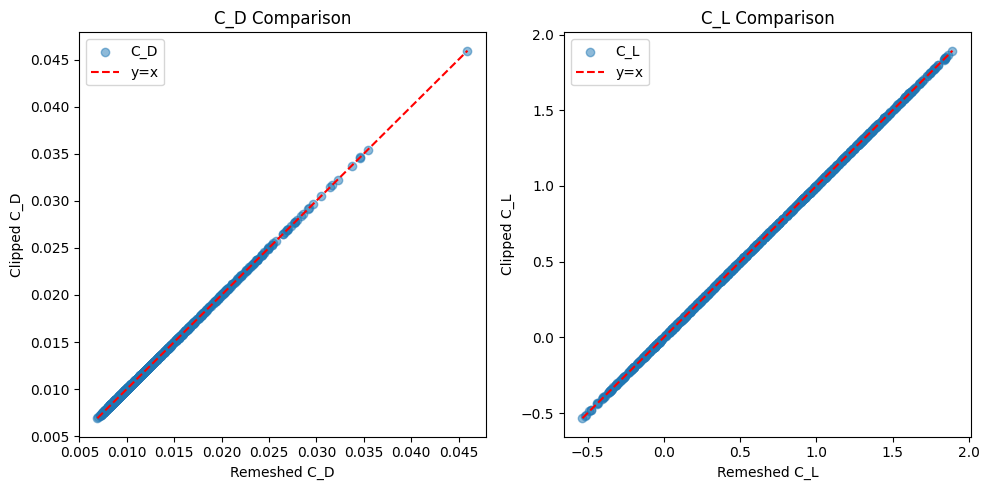

In [19]:
import pandas as pd
scalar_vals = []
rCDArr = []
cCDArr = []
rCLArr = []
cCLArr = []
for remeshed_mesh_path, clipped_mesh_path, remeshed_scalar_path, clipped_scalar_path in mesh_paths:
    remeshed_scalar = pd.read_csv(remeshed_scalar_path)
    clipped_scalar = pd.read_csv(clipped_scalar_path)
    rCD = remeshed_scalar['C_D'].values[0]
    rCL = remeshed_scalar['C_L'].values[0]
    cCD = clipped_scalar['C_D'].values[0]
    cCL = clipped_scalar['C_L'].values[0]
    CD_diff = cCD - rCD
    CL_diff = cCL - rCL

    scalar_vals.append((CD_diff, CL_diff))
    rCDArr.append(rCD)
    cCDArr.append(cCD)
    rCLArr.append(rCL)
    cCLArr.append(cCL)

print(f"Scalar values (CD_diff != 0, CL_diff != 0): {len([i for i in scalar_vals if i[0] != 0 or i[1] != 0] )}")

print(f"Remeshed C_D max: {max(rCDArr)}, min: {min(rCDArr)}")
print(f"Clipped C_D max: {max(cCDArr)}, min: {min(cCDArr)}")
print(f"Remeshed C_L max: {max(rCLArr)}, min: {min(rCLArr)}")
print(f"Clipped  C_L max: {max(cCLArr)}, min: {min(cCLArr)}")

# compare the two cd and cl values
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(rCDArr, cCDArr, label='C_D', alpha=0.5) 
plt.xlabel('Remeshed C_D')
plt.ylabel('Clipped C_D')
plt.title('C_D Comparison')
plt.plot([min(rCDArr), max(rCDArr)], [min(rCDArr), max(rCDArr)], color='red', linestyle='--', label='y=x')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(rCLArr, cCLArr, label='C_L', alpha=0.5)
plt.xlabel('Remeshed C_L')
plt.ylabel('Clipped C_L')
plt.title('C_L Comparison')
plt.plot([min(rCLArr), max(rCLArr)], [min(rCLArr), max(rCLArr)], color='red', linestyle='--', label='y=x')
plt.legend()
plt.tight_layout()
plt.show()

In [14]:
def process_mesh_pair(remeshed_path, clipped_path):
    """
    Process a pair of remeshed and clipped meshes with consistent scaling
    Args:
        remeshed_path (str): Path to remeshed mesh file
        clipped_path (str): Path to clipped mesh file  
    Returns:
        tuple: (remeshed_data, clipped_data, global_ranges) for consistent scaling
    """
    
    def extract_mesh_data(filepath, mesh_type):
        """Extract data from a single mesh file"""
        print(f"\nProcessing {mesh_type} mesh: {os.path.basename(filepath)}")
        
        # Read the mesh
        reader = pv.CGNSReader(filepath)
        reader.load_boundary_patch = False
        mesh = reader.read().combine()
        
        # Get bounds and create sampling plane
        bounds = mesh.bounds
        x_min, x_max, y_min, y_max, z_min, z_max = bounds
        resolution = 512
        
        plane = pv.Plane(center=[(x_min + x_max)/2, (y_min + y_max)/2, 0], 
                        direction=[0, 0, 1], 
                        i_size=x_max - x_min, 
                        j_size=y_max - y_min, 
                        i_resolution=resolution, 
                        j_resolution=resolution)
        
        # Sample the data
        sampled_mesh = plane.sample(mesh)
        n_points = sampled_mesh.n_points
        actual_resolution = int(np.sqrt(n_points))
        
        print(f"  Available arrays: {sampled_mesh.array_names}")
        print(f"  Resolution: {actual_resolution}x{actual_resolution}")
        
        # Extract data arrays
        data_dict = {}
        for array_name in ['nut', 'p', 'Ux', 'Uy', 'implicit_distance']:
            if array_name in sampled_mesh.array_names:
                data = sampled_mesh[array_name]
                
                # Reshape data
                if len(data) == actual_resolution * actual_resolution:
                    data = data.reshape(actual_resolution, actual_resolution)
                else:
                    # Interpolate to regular grid
                    from scipy.interpolate import griddata
                    points = sampled_mesh.points
                    x, y = points[:, 0], points[:, 1]
                    xi = np.linspace(x.min(), x.max(), resolution)
                    yi = np.linspace(y.min(), y.max(), resolution)
                    Xi, Yi = np.meshgrid(xi, yi)
                    data = griddata((x, y), data, (Xi, Yi), method='linear')
                
                data_dict[array_name] = data
                print(f"  {array_name}: range [{np.nanmin(data):.6f}, {np.nanmax(data):.6f}]")
        
        return data_dict, bounds
    
    # Process both meshes
    remeshed_data, remeshed_bounds = extract_mesh_data(remeshed_path, "REMESHED")
    clipped_data, clipped_bounds = extract_mesh_data(clipped_path, "CLIPPED")
    
    # Calculate global ranges for consistent scaling
    global_ranges = {}
    for var in ['nut', 'p', 'Ux', 'Uy']:
        if var in remeshed_data and var in clipped_data:
            # Find global min/max across both meshes
            remeshed_vals = remeshed_data[var]
            clipped_vals = clipped_data[var]
            
            global_min = min(np.nanmin(remeshed_vals), np.nanmin(clipped_vals))
            global_max = max(np.nanmax(remeshed_vals), np.nanmax(clipped_vals))
            
            global_ranges[var] = (global_min, global_max)
            print(f"\nGlobal range for {var}: [{global_min:.6f}, {global_max:.6f}]")
    
    return remeshed_data, clipped_data, global_ranges

def normalize_with_range(data, global_range):
    """Normalize data using global range for consistent scaling"""
    global_min, global_max = global_range
    if global_max == global_min:
        return np.zeros_like(data, dtype=np.uint8)
    normalized = (data - global_min) / (global_max - global_min)
    return (normalized * 255).astype(np.uint8)


In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# df = pd.DataFrame(columns=[
#     'p_path', 'nut_path', 'Ux_path', 'Uy_path', 
#     'p_label', 'nut_label', 'Ux_label', 'Uy_label',
#     'C_D', 'C_L', 'angle_of_attack', 'inlet_velocity'
#     'L_D_ratio', "base_label"
#     ])
all_data = []
output_dir = 'raw_data_images'
os.makedirs(output_dir, exist_ok=True)
for i, (remeshed_mesh_path, clipped_mesh_path, remeshed_scalar_path, clipped_scalar_path) in enumerate(mesh_paths):
    label = None
    data_object = {
        'p_path': None,
        'nut_path': None,
        'Ux_path': None,
        'Uy_path': None,
        'p_label': label,
        'nut_label': label,
        'Ux_label': label,
        'Uy_label': label,
        'C_D': None,
        'C_L': None,
        'angle_of_attack': None,
        'inlet_velocity': None
    }
    data = pd.read_csv(remeshed_scalar_path)

    data_object['C_D'] = data['C_D'].values[0]
    data_object['C_L'] = data['C_L'].values[0]
    data_object['angle_of_attack'] = data['angle_of_attack'].values[0]
    data_object['inlet_velocity'] = data['inlet_velocity'].values[0]

    data_object['L_D_ratio'] = data_object['C_D']/data_object['C_L']
    
    
    # Process both meshes
    remeshed_data, clipped_data, global_ranges = process_mesh_pair(remeshed_mesh_path, clipped_mesh_path)
    
    # Create consistently scaled images
    remeshed_images = {}
    clipped_images = {}

    # Process flow variables with consistent scaling
    for var in ['nut', 'p', 'Ux', 'Uy']:
        if var in global_ranges:
            remeshed_images[var] = normalize_with_range(remeshed_data[var], global_ranges[var])
            clipped_images[var] = normalize_with_range(clipped_data[var], global_ranges[var])
    
    for var, image in remeshed_images.items():
        filename = f'{i}_remeshed_{var}.png'
        file_path = os.path.join(output_dir, filename)
        plt.imsave(file_path, image, cmap='RdBu') 
        data_object[var + '_path'] = file_path

    # Save clipped images
    for var, image in clipped_images.items():
        filename = f'{i}_clipped_{var}.png'
        file_path = os.path.join(output_dir, filename)
        plt.imsave(file_path, image, cmap='RdBu') 
        data_object[var + '_path'] = file_path
    
    # df = df.append(data_object, ignore_index=True)
    all_data.append(data_object)

# Create DataFrame from all collected data
df = pd.DataFrame(all_data)
df['base_label'] = pd.qcut(df['L_D_ratio'], q=3,
                                  labels=['low_efficiency', 'medium_efficiency', 'high_efficiency'])



# Create the four unique label columns
for img_type in ['p', 'nut', 'ux', 'uy']:
    df[f'{img_type}_label'] = img_type + '_' + df['base_label'].astype(str)




Processing REMESHED mesh: mesh_000000000.cgns
  Available arrays: ['Ux', 'Uy', 'implicit_distance', 'nut', 'p', 'vtkOriginalPointIds', 'cell_ids', 'vtkOriginalCellIds', 'vtkValidPointMask', 'Normals', 'TextureCoordinates', 'vtkGhostType', 'vtkGhostType']
  Resolution: 513x513
  nut: range [0.000000, 0.005274]
  p: range [-580.084809, 474.401467]
  Ux: range [0.000000, 43.918259]
  Uy: range [-31.265326, 10.550596]
  implicit_distance: range [-3.354337, 0.000000]

Processing CLIPPED mesh: mesh_000000000.cgns
  Available arrays: ['Ux', 'Uy', 'implicit_distance', 'nut', 'p', 'zone_0', 'zone_1', 'zone_2', 'zone_3', 'zone_4', 'zone_5', 'vtkValidPointMask', 'Normals', 'TextureCoordinates', 'vtkGhostType', 'vtkGhostType']
  Resolution: 513x513
  nut: range [-0.000000, 0.005273]
  p: range [-580.088350, 474.201043]
  Ux: range [-0.000000, 43.906636]
  Uy: range [-31.224781, 10.547611]
  implicit_distance: range [-3.354337, 0.000000]

Global range for nut: [-0.000000, 0.005274]

Global range f

In [35]:
df.to_csv('mesh_data_summary.csv', index=False)

In [ ]:
def process_mesh_pair(remeshed_path, clipped_path, sample_index=0):
    """
    Process a pair of remeshed and clipped meshes with consistent scaling
    Args:
        remeshed_path (str): Path to remeshed mesh file
        clipped_path (str): Path to clipped mesh file  
        sample_index (int): Index of the sample for naming
    Returns:
        tuple: (remeshed_data, clipped_data, global_ranges) for consistent scaling
    """
    
    def extract_mesh_data(filepath, mesh_type):
        """Extract data from a single mesh file"""
        print(f"\nProcessing {mesh_type} mesh: {os.path.basename(filepath)}")
        
        # Read the mesh
        reader = pv.CGNSReader(filepath)
        reader.load_boundary_patch = False
        mesh = reader.read().combine()
        
        # Get bounds and create sampling plane
        bounds = mesh.bounds
        x_min, x_max, y_min, y_max, z_min, z_max = bounds
        resolution = 512
        
        plane = pv.Plane(center=[(x_min + x_max)/2, (y_min + y_max)/2, 0], 
                        direction=[0, 0, 1], 
                        i_size=x_max - x_min, 
                        j_size=y_max - y_min, 
                        i_resolution=resolution, 
                        j_resolution=resolution)
        
        # Sample the data
        sampled_mesh = plane.sample(mesh)
        n_points = sampled_mesh.n_points
        actual_resolution = int(np.sqrt(n_points))
        
        print(f"  Available arrays: {sampled_mesh.array_names}")
        print(f"  Resolution: {actual_resolution}x{actual_resolution}")
        
        # Extract data arrays
        data_dict = {}
        for array_name in ['nut', 'p', 'Ux', 'Uy', 'implicit_distance']:
            if array_name in sampled_mesh.array_names:
                data = sampled_mesh[array_name]
                
                # Reshape data
                if len(data) == actual_resolution * actual_resolution:
                    data = data.reshape(actual_resolution, actual_resolution)
                else:
                    # Interpolate to regular grid
                    from scipy.interpolate import griddata
                    points = sampled_mesh.points
                    x, y = points[:, 0], points[:, 1]
                    xi = np.linspace(x.min(), x.max(), resolution)
                    yi = np.linspace(y.min(), y.max(), resolution)
                    Xi, Yi = np.meshgrid(xi, yi)
                    data = griddata((x, y), data, (Xi, Yi), method='linear')
                
                data_dict[array_name] = data
                print(f"  {array_name}: range [{np.nanmin(data):.6f}, {np.nanmax(data):.6f}]")
        
        return data_dict, bounds
    
    # Process both meshes
    remeshed_data, remeshed_bounds = extract_mesh_data(remeshed_path, "REMESHED")
    clipped_data, clipped_bounds = extract_mesh_data(clipped_path, "CLIPPED")
    
    # Calculate global ranges for consistent scaling
    global_ranges = {}
    for var in ['nut', 'p', 'Ux', 'Uy']:
        if var in remeshed_data and var in clipped_data:
            # Find global min/max across both meshes
            remeshed_vals = remeshed_data[var]
            clipped_vals = clipped_data[var]
            
            global_min = min(np.nanmin(remeshed_vals), np.nanmin(clipped_vals))
            global_max = max(np.nanmax(remeshed_vals), np.nanmax(clipped_vals))
            
            global_ranges[var] = (global_min, global_max)
            print(f"\nGlobal range for {var}: [{global_min:.6f}, {global_max:.6f}]")
    
    return remeshed_data, clipped_data, global_ranges

def normalize_with_range(data, global_range):
    """Normalize data using global range for consistent scaling"""
    global_min, global_max = global_range
    if global_max == global_min:
        return np.zeros_like(data, dtype=np.uint8)
    normalized = (data - global_min) / (global_max - global_min)
    return (normalized * 255).astype(np.uint8)

def create_airfoil_mask(implicit_distance):
    """Create binary airfoil mask from implicit distance field"""
    # Airfoil is typically where implicit_distance <= 0
    mask = (implicit_distance <= 0).astype(np.uint8) * 255
    return mask

# Process the first mesh pair for testing
print("="*80)
print("PROCESSING FIRST MESH PAIR FOR COMPARISON")
print("="*80)

if len(mesh_paths) == 0: 
    raise ValueError("No mesh pairs found. Please check the data paths.")
# Get the first mesh pair
remeshed_path, clipped_path = mesh_paths[0]

# Process both meshes
remeshed_data, clipped_data, global_ranges = process_mesh_pair(remeshed_path, clipped_path, 0)

# Create consistently scaled images
remeshed_images = {}
clipped_images = {}

# Process flow variables with consistent scaling
for var in ['nut', 'p', 'Ux', 'Uy']:
    if var in global_ranges:
        remeshed_images[var] = normalize_with_range(remeshed_data[var], global_ranges[var])
        clipped_images[var] = normalize_with_range(clipped_data[var], global_ranges[var])
        print(f"✅ Created consistently scaled images for {var}")

#save the images in folder raw_data_images
output_dir = 'raw_data_images'
os.makedirs(output_dir, exist_ok=True)
# Save remeshed images
for var, image in remeshed_images.items():
    plt.imsave(os.path.join(output_dir, f'remeshed_{var}.png'), image, cmap='RdBu' if var == 'p' else 'gray')
    print(f"✅ Saved remeshed {var} image")

# Save clipped images
for var, image in clipped_images.items():
    plt.imsave(os.path.join(output_dir, f'clipped_{var}.png'), image, cmap='RdBu' if var == 'p' else 'gray')
    print(f"✅ Saved clipped {var} image") 

# Process airfoil masks (binary)
if 'implicit_distance' in remeshed_data:
    remeshed_images['airfoil_mask'] = create_airfoil_mask(remeshed_data['implicit_distance'])
if 'implicit_distance' in clipped_data:
    clipped_images['airfoil_mask'] = create_airfoil_mask(clipped_data['implicit_distance'])

print(f"\nRemeshed images: {list(remeshed_images.keys())}")
print(f"Clipped images: {list(clipped_images.keys())}")
    